In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
# torch.cuda.set_device(0)

/home/akai/virtualenvs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.backends.cudnn.benchmark=True

## Setup

In [7]:
PATH = Path('/mnt/data/dataset/pascal')
trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [8]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [9]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [30]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

## Multi class

In [31]:
MC_CSV = PATH/'tmp/mc.csv'

In [32]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [ ]:
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]; print(mc)
mcs = [' '.join(str(p) for p in o) for o in mc]

In [44]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)

In [45]:
df.head()

fn              clas
0  000012.jpg               car
1  000017.jpg      horse person
2  000023.jpg    bicycle person
3  000026.jpg               car
4  000032.jpg  person aeroplane

In [35]:
f_model=resnet34
sz=224
bs=64

In [36]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms, bs=bs)

In [14]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

In [15]:
lrf=learn.lr_find(1e-5,100)

epoch      trn_loss   val_loss   <lambda>   
    0      1.762408   21.980478  0.2045    



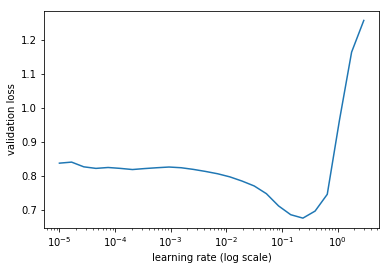

In [16]:
learn.sched.plot(0)

In [17]:
lr = 2e-2

In [18]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>   
    0      0.326388   0.138667   0.9563    
    1      0.172688   0.080906   0.9747    
    2      0.115367   0.075536   0.9751    



[array([0.07554]), 0.9751000008583068]

In [19]:
lrs = np.array([lr/100, lr/10, lr])

In [20]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:12<00:02,  2.15it/s, loss=0.272]

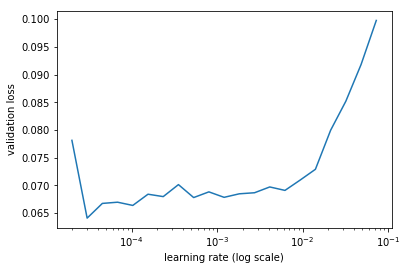

In [21]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [23]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>   
    0      0.075533   0.081022   0.9726    
    1      0.056591   0.079108   0.9737    
    2      0.041066   0.075723   0.9752    
    3      0.029073   0.078723   0.975     
    4      0.020925   0.075549   0.9759    


[0.07554885530471801, 0.9759000096321105]

In [24]:
learn.save('mclas')

In [25]:
learn.load('mclas')

In [26]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


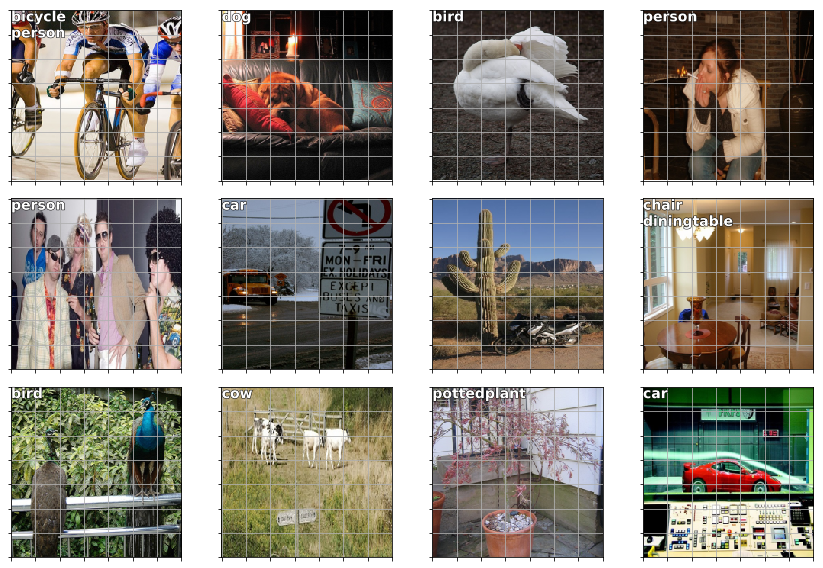

In [27]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i]>0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## Bbox per cell

### Set up data

In [17]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
sz=224
bs=64

In [48]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values()); print(id2cat)
cat2id = {v:k for k,v in enumerate(id2cat)}; print(cat2id)
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
{'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [19]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [20]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

In [21]:
df.head()

fn                                               bbox
0  000012.jpg                                     96 155 269 350
1  000017.jpg                       61 184 198 278 77 89 335 402
2  000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3  000026.jpg                                     124 89 211 336
4  000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

In [22]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

In [23]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [24]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((c>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [25]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [38]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [39]:
x,y=to_np(next(iter(md.val_dl)))
print(x.shape)
x=md.val_ds.ds.denorm(x)

(64, 3, 224, 224)


In [40]:
x[0].shape

(224, 224, 3)

In [41]:
x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)

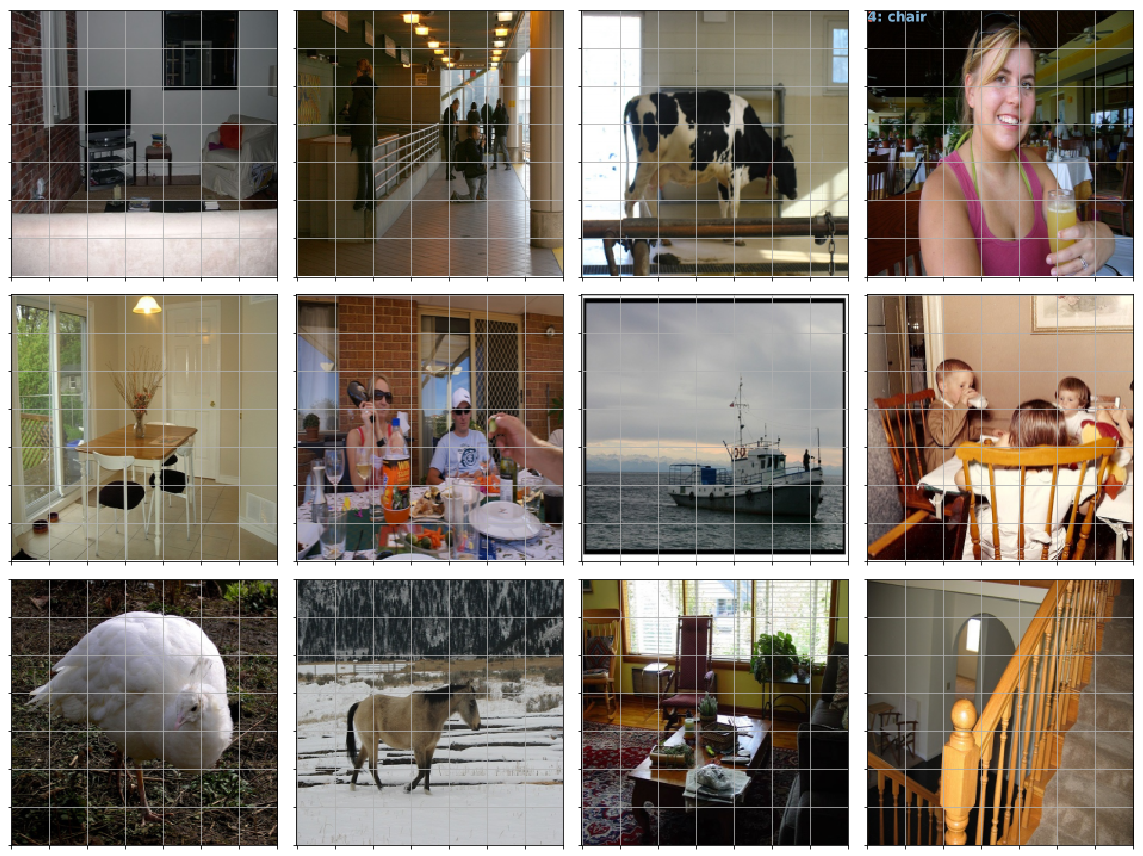

In [42]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

### Set up model

We're going to make a simple first model that simply predicts what object is located in each cell of a 4x4 grid. Later on we can try to improve this.

In [41]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [42]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

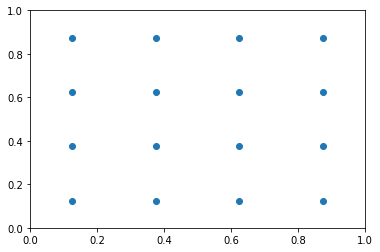

In [43]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [44]:
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]], device='cuda:0')

In [45]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [46]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]], device='cuda:0')

In [47]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)
n_clas, n_act

(21, 25)

In [48]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [49]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [50]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

### Train

In [51]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [52]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

### this part I'm not too sure about most!!!

In [53]:
_DEBUG = False # setting this to True to trigger pdb trace

In [50]:
def get_y(bbox,clas):
    """
    Keep only bounding boxes that class activation > 0. Correspondingly there are 
    14x4 = 56 box coordinates
    bbox: size (56,) of coordinates
    clas: size (14,) of classes
    Return the box coordinates resize to width/height of 1 and their corresponding classes
    """
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    """
    convert activation units into bounding boxes
    actn: (16,4) activation out of ???
    anchors: (16,4) list of anchor boxes of (center_x, center_y, width, height)
    return: (16, 4) for centers and w, h
    """
    actn_bbs = torch.tanh(actn)
    # remember that (x, y) in activation's (x, y, w, h) are the relative position to the anchor box center
    # we /2 here because it's defined that the gt box could be offset 1/2 grid size to the left or the the
    # right of the center of the anchor box. For example, x = 1 means that the center of predict box is 
    # on the far right of the anchor box, x = -1 means that the center of predict box is on the far left
    # of the anchor box. The '+' at the end is for the `relative part`. 
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    # likewise, the (w, h) are relative to the width and height of the anchor box. Here the defined range is:
    # when w = 1 => box's w = 1.5*anchor's width
    # when w = -1 => box's w = .5 * anchor's width
    # therefore the range of possible width is .5-1.5 anchor width
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    # convert activation bb in form (x, y, w, h) to (x1, y1, x2, y2)
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    """
    this step returns these numbers for each anchor box
    - the amount of overlaps with gt boxes, 1.99 means maximum overlap
    - the gt box with which each anchor box overlaps most
    
    overlaps: (x, 16) = amount of overlaps between activation bounding boxes and anchor boxes
    return:
        gt_overlap: (16,)
        gt_idx: (16,)
    
    """
    # for each gt box, find out which anchor box it overlaps most (1). This is
    # essentially "matches" those anchor boxes 1-to-1 to each gt object
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print('prior_overlap', prior_overlap.shape, prior_overlap)
    # for each anchor box, find out which gt box it overlaps with most (2). This is
    # for remaining unmatched anchor box, find the gt box with it has largest iou with. 
    # what results is that each gt object should have at least 1 matched anchor box, but 
    # some may have more than 1 matched anchor box.
    gt_overlap, gt_idx = overlaps.max(0)
    # for those anchor box in (1), mark them with maximum of value 1.99 for maximum overlap
    gt_overlap[prior_idx] = 1.99
    # for those anchor box in (2), mark them with the gt box they overlap most with from (1)
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    # get bbox with positive value
    bbox,clas = get_y(bbox,clas)
    # activate them and turn them into bounding boxes
    a_ic = actn_to_bb(b_bb, anchors)
    # calculate their overlaps with anchor boxes
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    # get the boxes that make sense
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    # get the classes of positive anchor boxes
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    # assign the rest of anchor boxes without any overlap to background
    # because let's say we have 20 classes with id from 0-19, then the 
    # class id of 20 is the background
    gt_clas[1-pos] = len(id2cat)
    # kind of duplicate the gt boxes into list of 16 boxes corresponding to the
    # 16 anchor boxes so that in the next line we could use the same indexing mechanism
    # to get the positive boxes locations
    gt_bbox = bbox[gt_idx]
    # calculate the location loss between anchor boxes and their corresponding calculated activation boxes
    # the # of row = number of gt boxes
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [51]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [52]:
for i,o in enumerate(y): y[i] = o.cuda()
learn.model.cuda()

NameError: name 'learn' is not defined

In [ ]:
batch = learn.model(x)

In [57]:
 # uncomment to debug on cpu
#anchors = anchors.cpu(); grid_sizes = grid_sizes.cpu(); anchor_cnr = anchor_cnr.cpu()

In [49]:
ssd_loss(batch, y, True)

NameError: name 'ssd_loss' is not defined

In [59]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

epoch      trn_loss   val_loss   
    0      97.807318  37949.707188


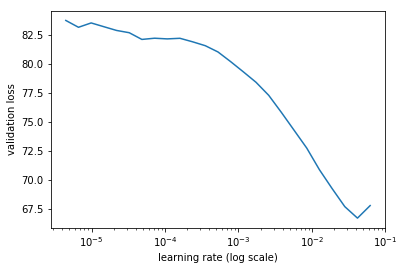

In [60]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [61]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss   
    0      42.88169   33.123102 
    1      33.744797  28.367259 
    2      29.339304  27.052766 
    3      26.57073   26.357081 
    4      24.43893   25.734632 


[25.734631530761717]

In [62]:
learn.save('0')

In [63]:
learn.load('0')

### Testing

In [64]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [65]:
b_clas.size(),b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

In [66]:
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

(tensor([[0.6786, 0.4866, 0.9911, 0.6250],
         [0.7098, 0.0848, 0.9911, 0.5491],
         [0.5134, 0.8304, 0.6696, 0.9063]], device='cuda:0'),
 tensor([ 8, 10, 17], device='cuda:0'))

In [67]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

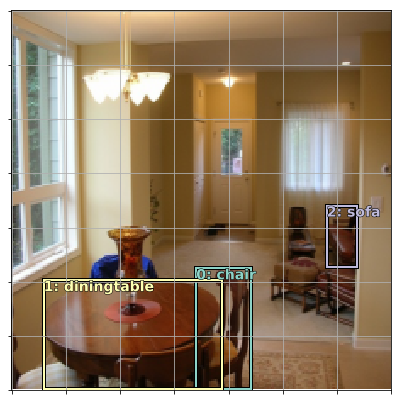

In [68]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

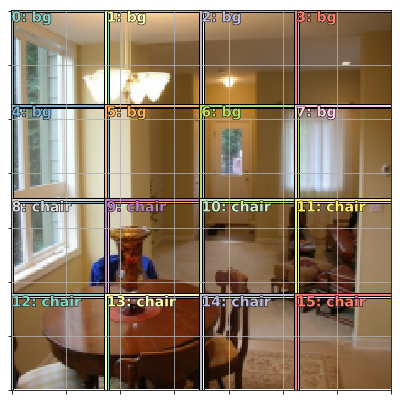

In [69]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [70]:
grid_sizes

tensor([[0.2500]], device='cuda:0')

In [71]:
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]], device='cuda:0')

In [73]:
a_ic = actn_to_bb(b_bboxi, anchors)
a_ic

tensor([[0.0721, 0.0263, 0.3239, 0.3346],
        [0.1222, 0.2744, 0.3027, 0.5411],
        [0.0523, 0.4189, 0.3901, 0.7383],
        [0.0657, 0.7482, 0.2318, 0.9126],
        [0.3693, 0.0839, 0.5105, 0.2213],
        [0.3957, 0.3429, 0.5291, 0.4687],
        [0.3471, 0.5602, 0.5649, 0.6881],
        [0.3436, 0.8064, 0.4929, 0.9327],
        [0.4916, 0.0876, 0.8413, 0.2686],
        [0.4951, 0.2969, 0.8648, 0.4555],
        [0.5265, 0.5225, 0.9012, 0.7463],
        [0.4911, 0.7861, 0.8392, 0.9279],
        [0.6347, 0.0492, 0.9929, 0.3003],
        [0.6034, 0.2475, 0.9773, 0.5772],
        [0.6012, 0.4434, 0.9758, 0.7925],
        [0.6229, 0.7174, 0.9740, 0.9448]],
       device='cuda:0', grad_fn=<CatBackward>)

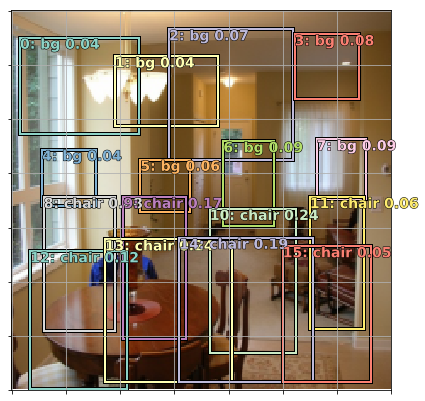

In [74]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

In [75]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0091, 0.0922, 0.0000, 0.0000, 0.0315, 0.3985, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0356,
         0.0549, 0.0103, 0.0000, 0.2598, 0.4538, 0.0653, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1897, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [76]:
overlaps.max(1)

(tensor([0.3985, 0.4538, 0.1897], device='cuda:0'),
 tensor([14, 13, 11], device='cuda:0'))

In [77]:
overlaps.max(0)

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0356,
         0.0549, 0.0922, 0.1897, 0.2598, 0.4538, 0.3985, 0.0000],
        device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0], device='cuda:0'))

In [78]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0356,
         0.0549, 0.0922, 1.9900, 0.2598, 1.9900, 1.9900, 0.0000],
        device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0], device='cuda:0'))

In [79]:
gt_clas = clas[gt_idx]; gt_clas

tensor([ 8,  8,  8,  8,  8,  8,  8,  8, 10, 10,  8, 17, 10, 10,  8,  8],
       device='cuda:0')

In [80]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
pos_idx

tensor([11, 13, 14], device='cuda:0')

In [81]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o<len(id2cat) else 'bg' for o in gt_clas.data]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'sofa',
 'bg',
 'diningtable',
 'chair',
 'bg']

In [82]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss  = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss

(tensor(0.0727, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.9117, device='cuda:0', grad_fn=<NllLossBackward>))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


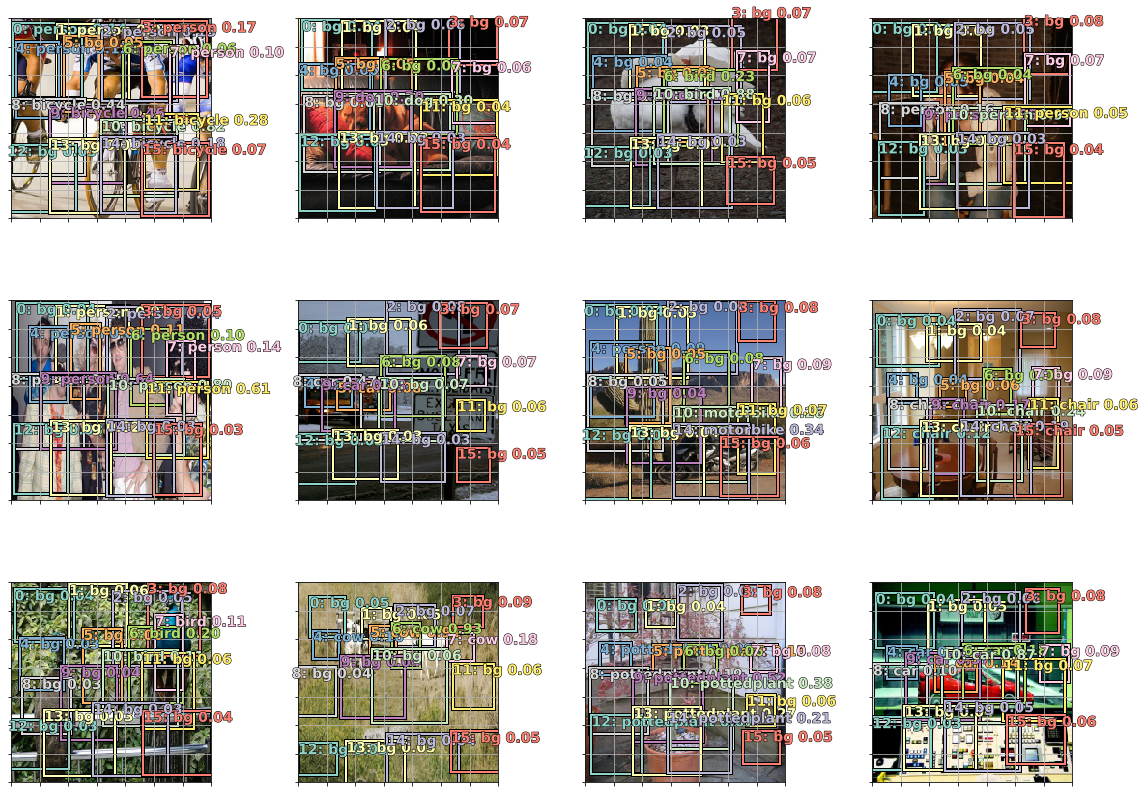

In [83]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(bbox,clas); bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()

## More anchors!

### Create anchors

In [84]:
anc_grids = [4,2,1]
# anc_grids = [2]
anc_zooms = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [85]:
anchor_scales

[(0.7, 0.7),
 (0.7, 0.35),
 (0.35, 0.7),
 (1.0, 1.0),
 (1.0, 0.5),
 (0.5, 1.0),
 (1.3, 1.3),
 (1.3, 0.65),
 (0.65, 1.3)]

In [86]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [90]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [91]:
anchors

tensor([[0.1250, 0.1250, 0.1750, 0.1750],
        [0.1250, 0.1250, 0.1750, 0.0875],
        [0.1250, 0.1250, 0.0875, 0.1750],
        [0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.1250, 0.2500, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.2500],
        [0.1250, 0.1250, 0.3250, 0.3250],
        [0.1250, 0.1250, 0.3250, 0.1625],
        [0.1250, 0.1250, 0.1625, 0.3250],
        [0.1250, 0.3750, 0.1750, 0.1750],
        [0.1250, 0.3750, 0.1750, 0.0875],
        [0.1250, 0.3750, 0.0875, 0.1750],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.1250],
        [0.1250, 0.3750, 0.1250, 0.2500],
        [0.1250, 0.3750, 0.3250, 0.3250],
        [0.1250, 0.3750, 0.3250, 0.1625],
        [0.1250, 0.3750, 0.1625, 0.3250],
        [0.1250, 0.6250, 0.1750, 0.1750],
        [0.1250, 0.6250, 0.1750, 0.0875],
        [0.1250, 0.6250, 0.0875, 0.1750],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.1250],
        [0.1250, 0.6250, 0.1250, 0

In [97]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [98]:
a=np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

b=[ 9.99399  2.72058 35.9703  44.4522 ] c=None pr=None


TypeError: '>' not supported between instances of 'NoneType' and 'int'

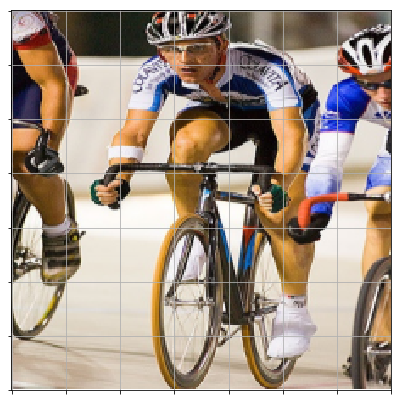

In [99]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

b=[ 9.99399  2.72058 35.9703  44.4522 ] c=None pr=None


TypeError: '>' not supported between instances of 'NoneType' and 'int'

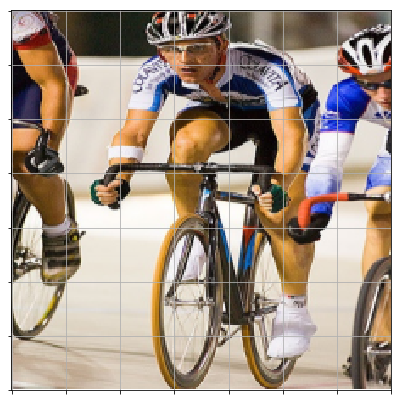

In [100]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

### Model

In [101]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [102]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [103]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(V(x))

In [104]:
batch[0].size(),batch[1].size()

(torch.Size([64, 189, 21]), torch.Size([64, 189, 4]))

In [105]:
ssd_loss(batch, y, True)

prior_overlap torch.Size([3]) tensor([0.5598, 0.7922, 0.3095], device='cuda:0')
prior_overlap torch.Size([2]) tensor([0.6075, 0.7035], device='cuda:0')
prior_overlap torch.Size([1]) tensor([0.7764], device='cuda:0')
prior_overlap torch.Size([1]) tensor([0.7268], device='cuda:0')
prior_overlap torch.Size([7]) tensor([0.5163, 0.4763, 0.3709, 0.4986, 0.2990, 0.0887, 0.1046], device='cuda:0')
prior_overlap torch.Size([1]) tensor([0.3789], device='cuda:0')
prior_overlap torch.Size([1]) tensor([0.5153], device='cuda:0')
prior_overlap torch.Size([3]) tensor([0.3985, 0.6215, 0.5742], device='cuda:0')
prior_overlap torch.Size([2]) tensor([0.4246, 0.5208], device='cuda:0')
prior_overlap torch.Size([3]) tensor([0.3426, 0.3257, 0.5062], device='cuda:0')
prior_overlap torch.Size([2]) tensor([0.9734, 0.2506], device='cuda:0')
prior_overlap torch.Size([1]) tensor([0.4477], device='cuda:0')
prior_overlap torch.Size([3]) tensor([0.7722, 0.5177, 0.6392], device='cuda:0')
prior_overlap torch.Size([1]) te

/home/akai/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(331.7515, device='cuda:0', grad_fn=<ThAddBackward>)

epoch      trn_loss   val_loss   
    0      334.805276 3668873.858


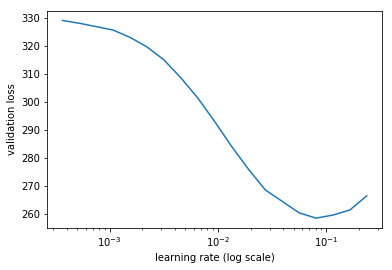

In [106]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

In [107]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss   
    0      157.907355 129.562046
    1      123.897204 101.412827
    2      106.326777 90.82436  
    3      94.930764  86.813799 


[86.81379913330078]

In [108]:
learn.save('tmp')

In [109]:
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss   
    0      89.215483  108.422031
    1      85.088752  87.128205 
    2      77.125377  79.90831  
    3      69.802043  76.41536  


[76.41535974121093]

In [110]:
learn.save('prefocal')

In [ ]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.21)
plt.tight_layout()

## Focal loss

In [113]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [114]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

In [115]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(x)
ssd_loss(batch, y, True)

prior_overlap torch.Size([3]) tensor([0.5598, 0.7922, 0.3095], device='cuda:0')
prior_overlap torch.Size([2]) tensor([0.6075, 0.7035], device='cuda:0')
prior_overlap torch.Size([1]) tensor([0.7764], device='cuda:0')
prior_overlap torch.Size([1]) tensor([0.7268], device='cuda:0')
prior_overlap torch.Size([7]) tensor([0.5163, 0.4763, 0.3709, 0.4986, 0.2990, 0.0887, 0.1046], device='cuda:0')
prior_overlap torch.Size([1]) tensor([0.3789], device='cuda:0')
prior_overlap torch.Size([1]) tensor([0.5153], device='cuda:0')
prior_overlap torch.Size([3]) tensor([0.3985, 0.6215, 0.5742], device='cuda:0')
prior_overlap torch.Size([2]) tensor([0.4246, 0.5208], device='cuda:0')
prior_overlap torch.Size([3]) tensor([0.3426, 0.3257, 0.5062], device='cuda:0')
prior_overlap torch.Size([2]) tensor([0.9734, 0.2506], device='cuda:0')
prior_overlap torch.Size([1]) tensor([0.4477], device='cuda:0')
prior_overlap torch.Size([3]) tensor([0.7722, 0.5177, 0.6392], device='cuda:0')
prior_overlap torch.Size([1]) te

/home/akai/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(21.0704, device='cuda:0', grad_fn=<ThAddBackward>)

 91%|█████████ | 29/32 [00:28<00:01,  1.87it/s, loss=27.9]

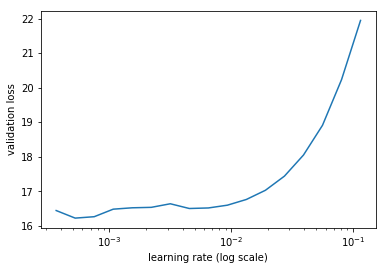

In [116]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=1)

In [117]:
learn.fit(lrs, 1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss   
    0      19.035798  79.503704 
    1      22.004218  32.242145 
    2      21.093427  21.051484 
    3      19.51269   20.19806  
    4      17.984609  18.079963 
    5      16.724616  17.685794 
    6      15.600219  17.091633 
    7      14.647715  16.876508 
    8      13.79165   16.50774  
    9      13.104551  16.341253 


[16.341252922058107]

In [118]:
learn.save('fl0')

In [119]:
learn.load('fl0')

In [120]:
learn.freeze_to(-2)
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss   
    0      12.114691  17.102901 
    1      12.368186  17.031904 
    2      12.182855  16.71616  
    3      11.806862  16.680091 
    4      11.4715    16.507493 
    5      11.128736  16.250265 
    6      10.734336  16.301119 
    7      10.347968  16.272969 
    8      9.998899   16.109122 
    9      9.739302   16.198256 


[16.19825621032715]

In [121]:
learn.save('drop4')

In [122]:
learn.load('drop4')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


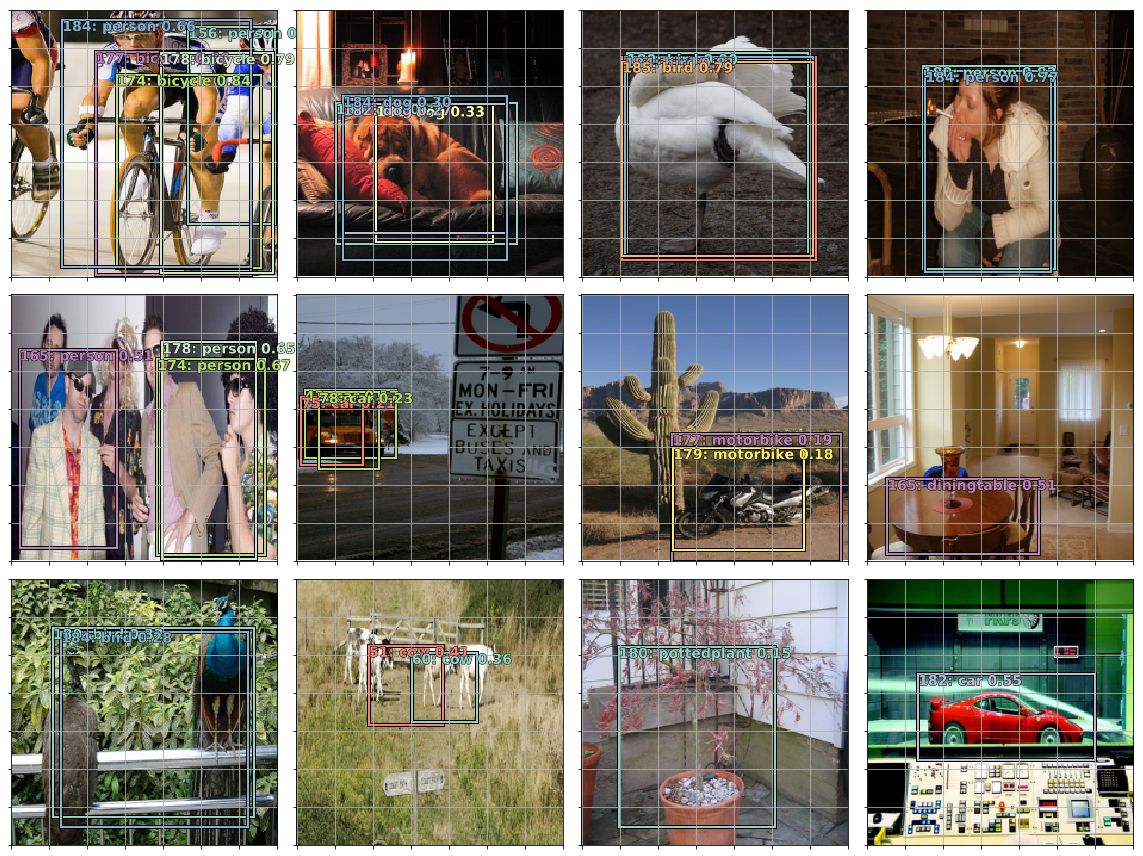

In [ ]:
plot_results(0.75)

## NMS

In [123]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [124]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

In [125]:
def show_nmf(idx):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    if not cc:
        print(f"{i}: empty array")
        return
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

b=[ -3  96  55 100] c=1 pr=0.5118195414543152
b=[ 94  59 123 162] c=1 pr=0.4892905056476593
b=[ 11  84 140 145] c=1 pr=0.3232211172580719
b=[ 38   3 153 210] c=14 pr=0.762238621711731
b=[118  11  99 169] c=14 pr=0.26480862498283386
b=[ 11  75 192 114] c=17 pr=0.39443957805633545
b=[ 45  25 134 187] c=2 pr=0.7390843033790588
b=[ 41  29  96 186] c=14 pr=0.7623701691627502
b=[ 92  25  49 184] c=14 pr=0.49866756796836853
b=[135  35  80 186] c=14 pr=0.3658628761768341
b=[171  79  46 110] c=14 pr=0.2807561159133911
b=[ 24  25  65 193] c=14 pr=0.27406689524650574
5: empty array
b=[103 137  98  72] c=1 pr=0.3068676292896271
b=[133 131  25  39] c=8 pr=0.278076708316803
8: empty array


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b=[57 51 59 64] c=9 pr=0.3425140082836151
b=[74 43 23 55] c=9 pr=0.28701597452163696
10: empty array
b=[ 48  89 124  59] c=6 pr=0.419606477022171


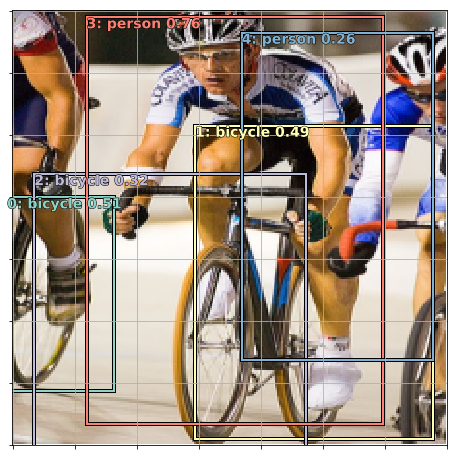

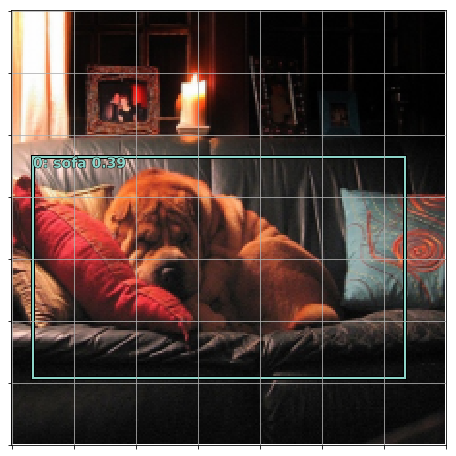

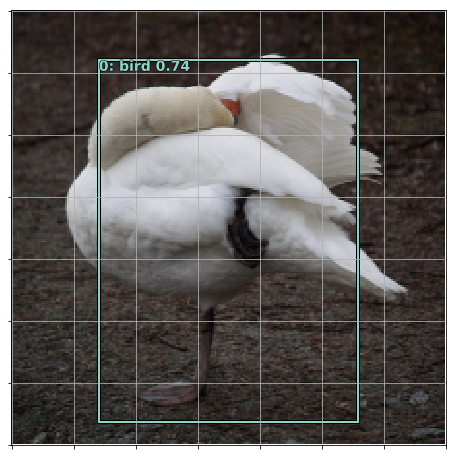

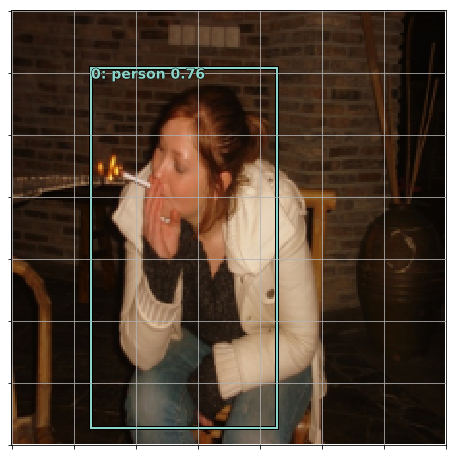

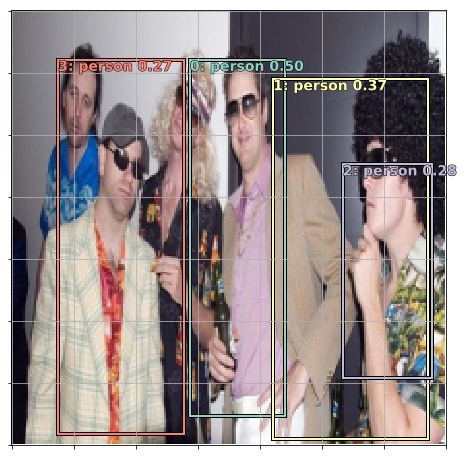

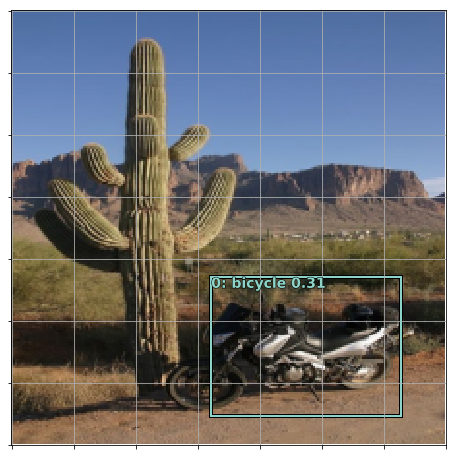

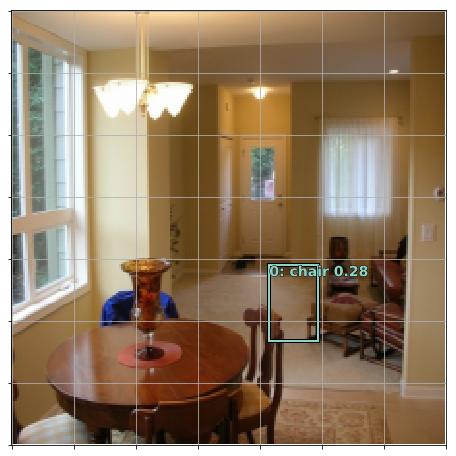

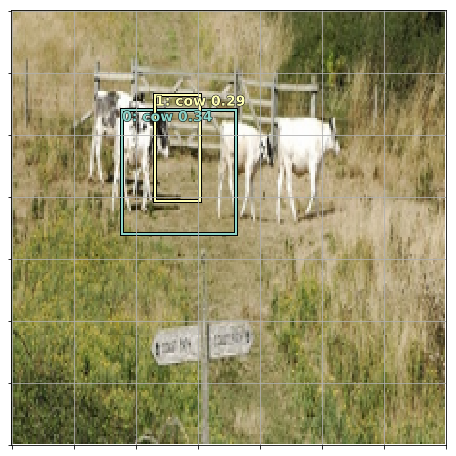

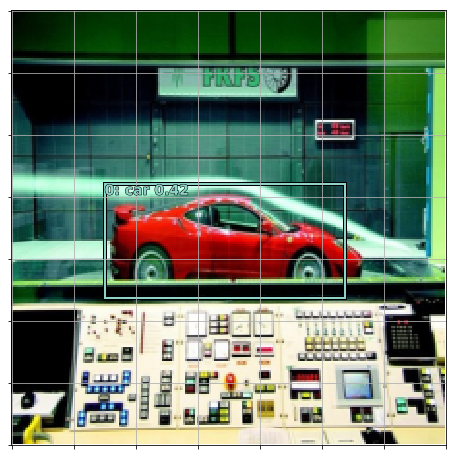

In [126]:
for i in range(12): show_nmf(i)

## End